# UE22CS342AA2: Data Analytics - Worksheet 3b
# ARIMAX, SARIMAX and LSTMs

Designed by Anshul Ranjan, Dept.of CSE - itsanshulranjan@gmail.com

## Student Details

• Name:Sanjana Boggaram J

• SRN:PES1UG22CS524

• Section:I

In the previous worksheet, we experimented with ARIMA models. However, one caveat of ARIMA (or similar models), is that it takes only the target variable into consideration, according to the timestamp. In essence, it derives the relationship between the current target variable values and the past variable values.

However, what if we have some other external factors affecting the target values?
This is where *ARIMAX* (AutoRegressive Integrated Moving Average with eXogenous variables) steps in!

ARIMAX extends the capabilities of ARIMA by incorporating external factors or exogenous variables that influence the time series data. It's the bridge that connects the simplicity of ARIMA with the complexity of real-world forecasting, allowing us to tackle more intricate and realistic forecasting challenges.

In [3]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.preprocessing import MinMaxScaler
import statsmodels.api as sm
from statsmodels.tsa.statespace.sarimax import SARIMAX

import math
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

import warnings

warnings.filterwarnings("ignore")

## Loading the data

The data is already divided into Test and Train Set!!! But always remember Before you try to forecast anything split the dataset into train-test sets, as discussed in the previous worksheet. Remember, since we're dealing with time series data, we will not perform a random split! 

In [4]:
train = pd.read_csv("/kaggle/input/ist-traffic-and-weather-time-series-dataset/Train.csv", encoding = "unicode_escape")
test = pd.read_csv("/kaggle/input/ist-traffic-and-weather-time-series-dataset/Test.csv", encoding = "unicode_escape")

In [5]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 33750 entries, 0 to 33749
Data columns (total 15 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   date_time            33750 non-null  object 
 1   is_holiday           43 non-null     object 
 2   air_pollution_index  33750 non-null  int64  
 3   humidity             33750 non-null  int64  
 4   wind_speed           33750 non-null  int64  
 5   wind_direction       33750 non-null  int64  
 6   visibility_in_miles  33750 non-null  int64  
 7   dew_point            33750 non-null  int64  
 8   temperature          33750 non-null  float64
 9   rain_p_h             33750 non-null  float64
 10  snow_p_h             33750 non-null  float64
 11  clouds_all           33750 non-null  int64  
 12  weather_type         33750 non-null  object 
 13  weather_description  33750 non-null  object 
 14  traffic_volume       33750 non-null  int64  
dtypes: float64(3), int64(8), object(4)
m

In [6]:
# Checking for NULL values in the Data
train.isnull().sum()

date_time                  0
is_holiday             33707
air_pollution_index        0
humidity                   0
wind_speed                 0
wind_direction             0
visibility_in_miles        0
dew_point                  0
temperature                0
rain_p_h                   0
snow_p_h                   0
clouds_all                 0
weather_type               0
weather_description        0
traffic_volume             0
dtype: int64

In [7]:
train.describe()

,air_pollution_index,humidity,wind_speed,wind_direction,visibility_in_miles,dew_point,temperature,rain_p_h,snow_p_h,clouds_all,traffic_volume
count,33750.000000,33750.000000,33750.000000,33750.000000,33750.000000,33750.000000,33750.000000,33750.000000,33750.000000,33750.000000,33750.000000
mean,154.841422,71.209007,3.378193,199.471852,4.989748,4.989748,280.069587,0.448739,0.000318,50.458785,3240.118163
std,83.735515,16.852248,2.055792,99.841088,2.570021,2.570021,13.415256,53.526500,0.009760,38.871734,1991.487289
min,10.000000,13.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,83.000000,60.000000,2.000000,130.000000,3.000000,3.000000,271.720000,0.000000,0.000000,1.000000,1165.250000
50%,155.000000,72.000000,3.000000,200.000000,5.000000,5.000000,280.150000,0.000000,0.000000,64.000000,3335.000000
75%,228.000000,85.000000,5.000000,290.000000,7.000000,7.000000,290.620000,0.000000,0.000000,90.000000,4926.000000
max,299.000000,100.000000,16.000000,360.000000,9.000000,9.000000,308.240000,9831.300000,0.510000,100.000000,7280.000000


In [8]:
train.head(10)

,date_time,is_holiday,air_pollution_index,humidity,wind_speed,wind_direction,visibility_in_miles,dew_point,temperature,rain_p_h,snow_p_h,clouds_all,weather_type,weather_description,traffic_volume
0,2012-10-02 09:00:00,NaN,121,89,2,329,1,1,288.28,0.0,0.0,40,Clouds,scattered clouds,5545
1,2012-10-02 10:00:00,NaN,178,67,3,330,1,1,289.36,0.0,0.0,75,Clouds,broken clouds,4516
2,2012-10-02 11:00:00,NaN,113,66,3,329,2,2,289.58,0.0,0.0,90,Clouds,overcast clouds,4767
3,2012-10-02 12:00:00,NaN,20,66,3,329,5,5,290.13,0.0,0.0,90,Clouds,overcast clouds,5026
4,2012-10-02 13:00:00,NaN,281,65,3,329,7,7,291.14,0.0,0.0,75,Clouds,broken clouds,4918
5,2012-10-02 14:00:00,NaN,23,65,3,328,6,6,291.72,0.0,0.0,1,Clear,sky is clear,5181
6,2012-10-02 15:00:00,NaN,184,64,3,328,7,7,293.17,0.0,0.0,1,Clear,sky is clear,5584
7,2012-10-02 16:00:00,NaN,167,64,3,327,7,7,293.86,0.0,0.0,1,Clear,sky is clear,6015
8,2012-10-02 17:00:00,NaN,119,63,3,327,6,6,294.14,0.0,0.0,20,Clouds,few clouds,5791
9,2012-10-02 18:00:00,NaN,161,63,3,326,3,3,293.10,0.0,0.0,20,Clouds,few clouds,4770


### Data Dictionary:

* **date_time**: Date, time, and hour of the data collected in local IST time.
* **is_holiday**: Categorical indicator of Indian national and regional holidays.
* **air_pollution_index**: Air Quality Index (range: 10-300).
* **humidity**: Numeric humidity in Celsius.
* **wind_speed**: Numeric wind speed in miles per hour.
* **wind_direction**: Cardinal wind direction (0-360 degrees).
* **visibility_in_miles**: Visibility distance in miles.
* **dew_point**: Numeric dew point in Celsius.
* **temperature**: Numeric average temperature in Kelvin.
* **rain_p_h**: Numeric amount of rain in millimeters that occurred during the hour.
* **snow_p_h**: Numeric amount of snow in millimeters that occurred during the hour.
* **clouds_all**: Numeric percentage of cloud cover.
* **weather_type**: Categorical short description of the current weather.
* **weather_description**: Categorical longer description of the current weather conditions.
* **traffic_volume**: Numeric hourly traffic volume bound in a specific direction.

We intend to perform traffic volume forecasting for each hour based on the provided time series data. Given the nature of traffic patterns, it is likely that certain times of the day, days of the week, and possibly even specific months may exhibit higher traffic volumes compared to others. This variation can often be attributed to factors such as holidays, weather conditions, and other exogenous variables.

To accurately forecast the traffic_volume attribute, we will leverage time series methods, specifically the SARIMAX (Seasonal Autoregressive Integrated Moving Average with eXogenous variables) model. This model is well-suited for capturing seasonal patterns and incorporating the influence of external factors such as air quality, weather conditions, and holidays, which can affect traffic flow. By accounting for these variables, we aim to produce precise forecasts that reflect the complex interplay of time-dependent and external influences on traffic volume.

Remember, we are performing time series analysis here. A general rule of thumb is to have the `time` column as the index column!

This line sets the  column date_time as the index of the DataFrame, allowing for time-based indexing and operations. It helps in organizing the data by date and is useful for time series analysis.

In [9]:
train.index = train.date_time
train = train.drop(['date_time'],axis=1)
train.head()

,is_holiday,air_pollution_index,humidity,wind_speed,wind_direction,visibility_in_miles,dew_point,temperature,rain_p_h,snow_p_h,clouds_all,weather_type,weather_description,traffic_volume
date_time,,,,,,,,,,,,,,
2012-10-02 09:00:00,NaN,121,89,2,329,1,1,288.28,0.0,0.0,40,Clouds,scattered clouds,5545
2012-10-02 10:00:00,NaN,178,67,3,330,1,1,289.36,0.0,0.0,75,Clouds,broken clouds,4516
2012-10-02 11:00:00,NaN,113,66,3,329,2,2,289.58,0.0,0.0,90,Clouds,overcast clouds,4767
2012-10-02 12:00:00,NaN,20,66,3,329,5,5,290.13,0.0,0.0,90,Clouds,overcast clouds,5026
2012-10-02 13:00:00,NaN,281,65,3,329,7,7,291.14,0.0,0.0,75,Clouds,broken clouds,4918


This plot will help visualize trends in average daily traffic_volume over time, showing if traffic_volume are increasing, decreasing, or following any patterns across dates.

<Axes: xlabel='date_time'>

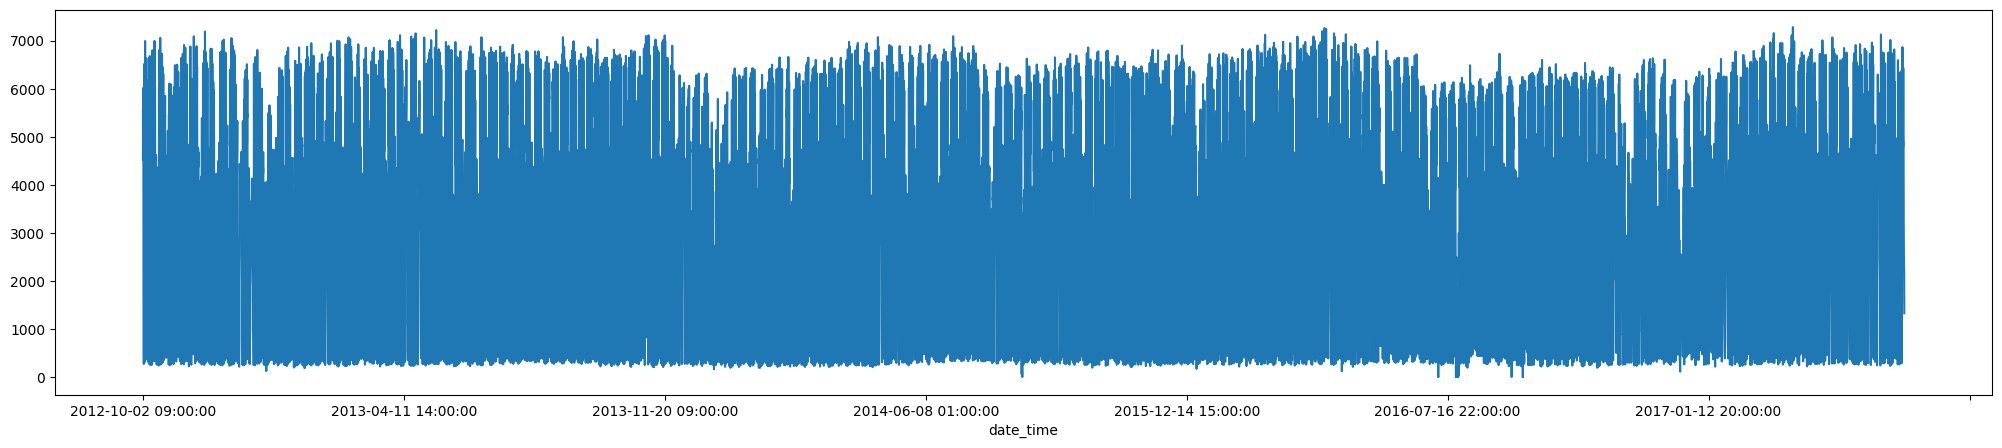

In [10]:
train['traffic_volume'].plot(figsize=(25,5))

## Data Preprocessing

For handling categorical variables **is_holiday, weather_type, weather_description,** we perform one-hot encoding

In [11]:
from tqdm import tqdm

def pre_process(data):
    data['holiday'] = 0
    for i in tqdm(range(len(data))):
        if(data.iloc[i]['is_holiday'] != "None"):
            data.iloc[i]['holiday'] = 1
    weather_type = pd.get_dummies(data['weather_type'],prefix="weather_type")
    weather_desc = pd.get_dummies(data['weather_description'],prefix="weather_desc")
    data = data.drop(['weather_type','weather_description','is_holiday'],axis=1)
    data = pd.concat([data,weather_type,weather_desc],axis=1)
    data.head()
    return(data)

In [12]:
train = pre_process(train)

100%|██████████| 33750/33750 [00:07<00:00, 4411.04it/s]


## Augmented Dickey-Fuller Test

In [13]:
t = sm.tsa.adfuller(train.traffic_volume, autolag='AIC')
pd.Series(t[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])

Test Statistic                   -23.77966
p-value                            0.00000
#Lags Used                        48.00000
Number of Observations Used    33701.00000
dtype: float64

The results suggest that the time series data you analyzed is **likely stationary**, meaning it does not have a unit root and its statistical properties do not change over time.

## Decomposition of elements

In [14]:
s = sm.tsa.seasonal_decompose(train.traffic_volume, period=12)

<Axes: xlabel='date_time'>

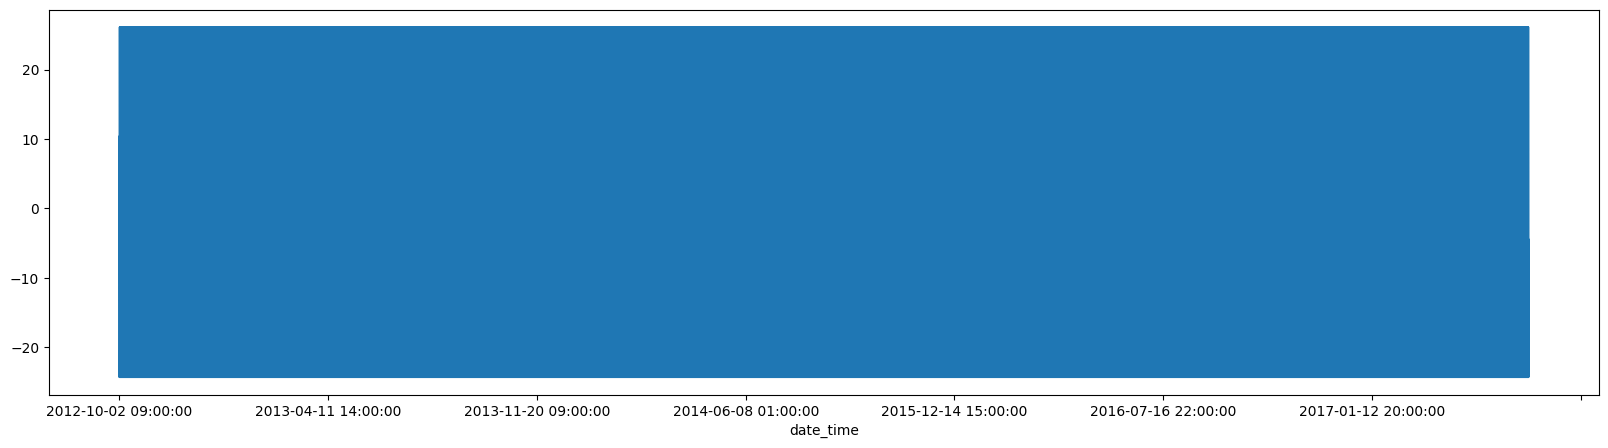

In [15]:
s.seasonal.plot(figsize=(20,5))

<Axes: xlabel='date_time'>

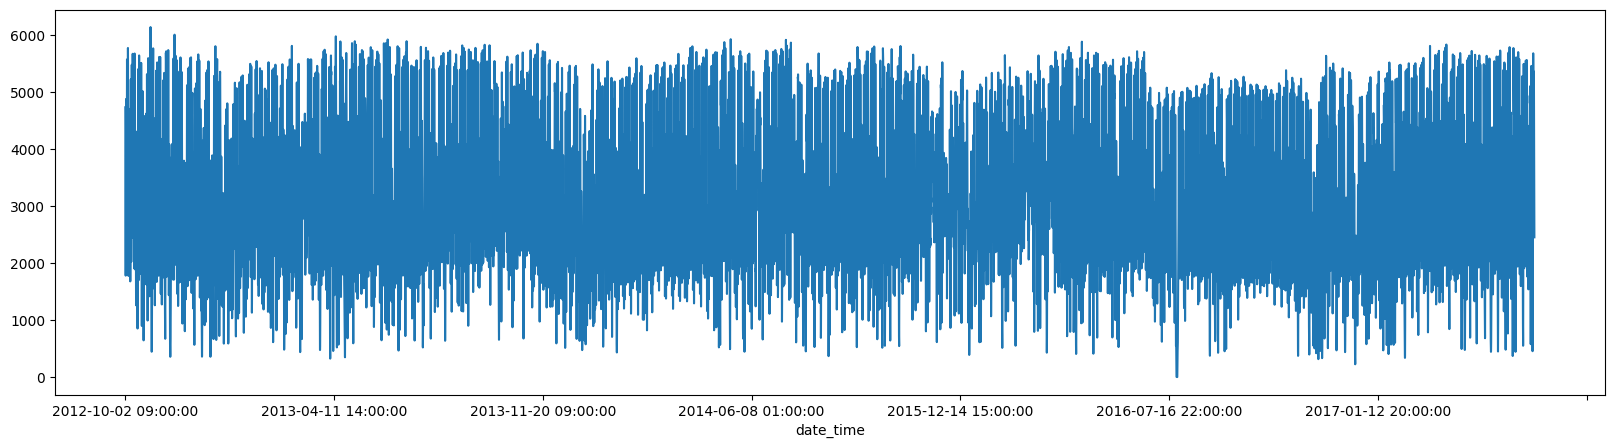

In [16]:
s.trend.plot(figsize=(20,5))

<Axes: xlabel='date_time'>

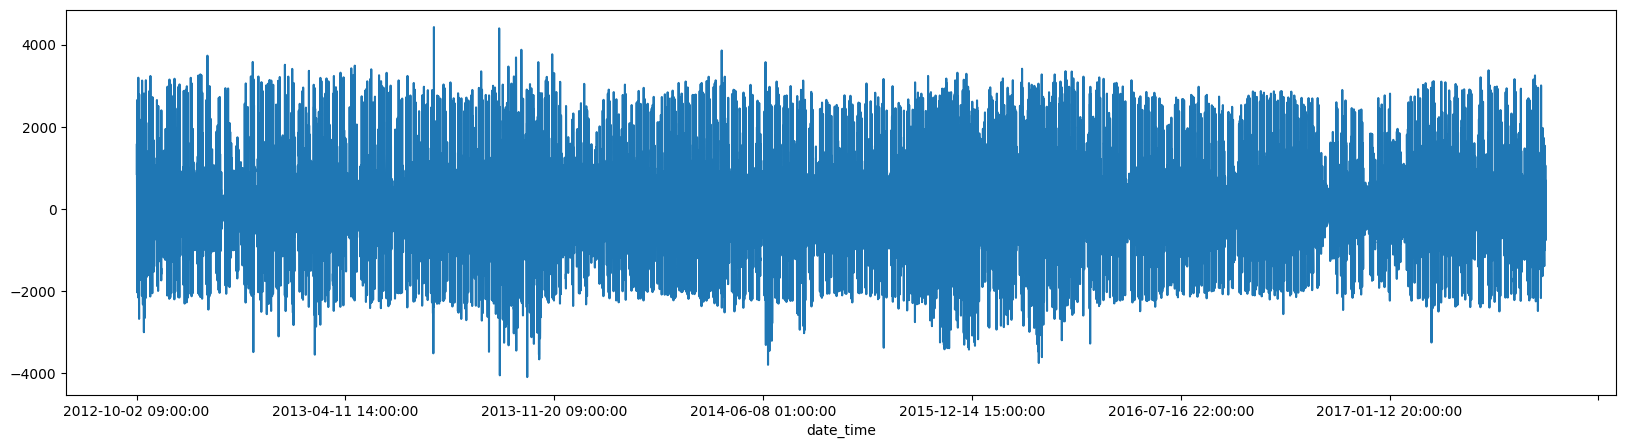

In [17]:
s.resid.plot(figsize=(20,5))

## ARIMAX Model

In [18]:
train.columns

Index(['air_pollution_index', 'humidity', 'wind_speed', 'wind_direction',
       'visibility_in_miles', 'dew_point', 'temperature', 'rain_p_h',
       'snow_p_h', 'clouds_all', 'traffic_volume', 'holiday',
       'weather_type_Clear', 'weather_type_Clouds', 'weather_type_Drizzle',
       'weather_type_Fog', 'weather_type_Haze', 'weather_type_Mist',
       'weather_type_Rain', 'weather_type_Smoke', 'weather_type_Snow',
       'weather_type_Squall', 'weather_type_Thunderstorm',
       'weather_desc_SQUALLS', 'weather_desc_Sky is Clear',
       'weather_desc_broken clouds', 'weather_desc_drizzle',
       'weather_desc_few clouds', 'weather_desc_fog',
       'weather_desc_freezing rain', 'weather_desc_haze',
       'weather_desc_heavy intensity drizzle',
       'weather_desc_heavy intensity rain', 'weather_desc_heavy snow',
       'weather_desc_light intensity drizzle',
       'weather_desc_light intensity shower rain', 'weather_desc_light rain',
       'weather_desc_light rain and snow', 

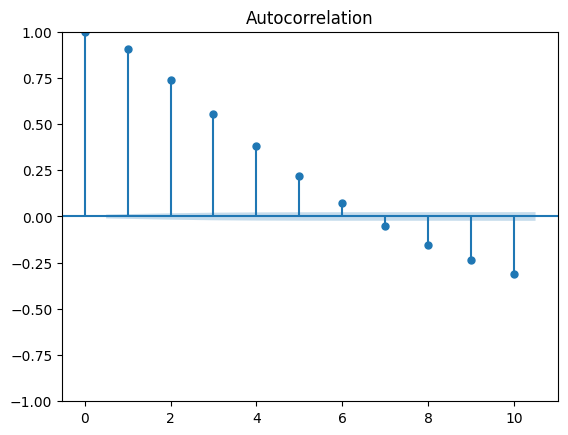

In [19]:
plot_acf(train.traffic_volume,lags=10)
plt.show()

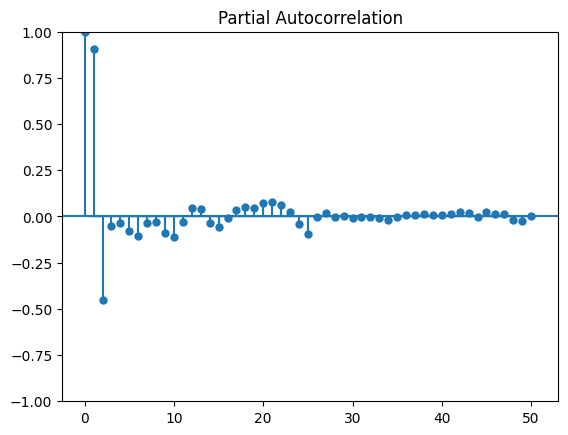

In [20]:
plot_pacf(train.traffic_volume,lags=50)
plt.show()

Here, we define an algorithm which takes in a range of values of p, d, q and calculates the AIC metric on a vanilla ARIMA model. 

The **Akaike Information Criterion (AIC)** is a statistical measure used for model selection and comparison in the context of regression analysis and time series modeling.

AIC quantifies the trade-off between a model's goodness of fit and its complexity, penalizing models with too many parameters. It is employed to choose the best-fitting model among a set of candidate models. The model with the lowest AIC value is typically preferred because it represents a good balance between explaining the data and avoiding overfitting.

### Please dont run this code just for reference 

In [ ]:
'''
#Finding the best value for ARIMA
import warnings
warnings.filterwarnings("ignore")

import itertools 
p=q=range (0,7)
d = range(0,2)
pdq = list(itertools.product (p, d, q))

store = {}
for param in pdq:
       try:
              model_arima = sm.tsa.arima.ARIMA (train.traffic_volume, order = param)
              model_arima_fit = model_arima.fit()
              store[param] =  model_arima_fit.aic  
              #print(param, model_arima_fit.aic)
       except:
              continue
          
sorted_dict = dict(sorted(store.items(), key=lambda item: item[1]))
print(sorted_dict)
# The Akaike information criterion (AIC) is an estimator of in-sample prediction error and thereby relative quality of
# statistical models for a given set of data
# It's like the mean squared error in Regression - The smaller the number, the better
'''

### Assume  **p = 1 , d = 0, q = 1**

## Specify endogenous and exogenous variables in the data

In [21]:
# Drop the 'traffic_volume' column from the training data to create the exogenous variables dataset
exog_columns = [
    'air_pollution_index',
    'humidity',
    'wind_speed',
    'wind_direction',
    'visibility_in_miles',
    'dew_point',
    'temperature',
    'rain_p_h',
    'snow_p_h',
    'clouds_all'
]

# Select only these columns from the DataFrame
exog_data = train[exog_columns]


# Add a constant term (intercept) to the exogenous variables dataset
exog = sm.add_constant(exog_data)

# Select the 'traffic_volume' column from the training data as the endogenous variable (target)
endog = train['traffic_volume']

In [22]:
exog.dtypes

const                  float64
air_pollution_index      int64
humidity                 int64
wind_speed               int64
wind_direction           int64
visibility_in_miles      int64
dew_point                int64
temperature            float64
rain_p_h               float64
snow_p_h               float64
clouds_all               int64
dtype: object

In [23]:
mod = sm.tsa.statespace.SARIMAX(endog=endog, exog=exog, order=(1,0,1))
model_fit = mod.fit()
model_fit.summary()

# Can use model_fit = mod.fit(maxiter=5) or model_fit = mod.fit(maxiter=10) if its taking too much time to run

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           14     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.07429D+00    |proj g|=  5.62121D-02

At iterate    5    f=  8.07177D+00    |proj g|=  9.87528D-03

At iterate   10    f=  8.07030D+00    |proj g|=  3.12046D-03

At iterate   15    f=  8.06857D+00    |proj g|=  3.51209D-04

At iterate   20    f=  8.06851D+00    |proj g|=  4.87439D-04

At iterate   25    f=  8.06850D+00    |proj g|=  8.32368D-04

At iterate   30    f=  8.06835D+00    |proj g|=  3.45635D-04

At iterate   35    f=  8.06830D+00    |proj g|=  1.52919D-04

At iterate   40    f=  8.06830D+00    |proj g|=  2.63849D-04

At iterate   45    f=  8.06827D+00    |proj g|=  4.61303D-04

At iterate   50    f=  8.06823D+00    |proj g|=  9.83127D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:         traffic_volume   No. Observations:                33750
Model:               SARIMAX(1, 0, 1)   Log Likelihood             -272302.723
Date:                Fri, 25 Oct 2024   AIC                         544633.445
Time:                        16:35:08   BIC                         544751.420
Sample:                             0   HQIC                        544671.088
                              - 33750                                         
Covariance Type:                  opg                                         
=======================================================================================
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
const               -2804.4871     97.544    -28.751      0.000   -2995.670   -2613.304
air_pollution_index    -0.0175      0.030     -0.578      0.563      -0.077       0.042
humidity                1.1466      0.590      1.944      0.052      -0.009       2.303
wind_speed             19.0366      3.174      5.999      0.000      12.817      25.257
wind_direction         -0.0891      0.059     -1.505      0.132      -0.205       0.027
visibility_in_miles    -1.0887      0.500     -2.177      0.029      -2.069      -0.109
dew_point              -1.0887      0.500     -2.177      0.029      -2.069      -0.109
temperature            21.2365      0.256     82.876      0.000      20.734      21.739
rain_p_h                0.0252      0.047      0.537      0.591      -0.067       0.117
snow_p_h              443.8983    813.901      0.545      0.585   -1151.319    2039.116
clouds_all              0.0539      0.153      0.353      0.724      -0.246       0.354
ar.L1                   0.8498      0.004    215.580      0.000       0.842       0.857
ma.L1                   0.3942      0.004    110.185      0.000       0.387       0.401
sigma2               6.131e+05   3138.255    195.370      0.000    6.07e+05    6.19e+05
===================================================================================
Ljung-Box (L1) (Q):                 151.18   Jarque-Bera (JB):             80222.15
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               0.73   Skew:                             1.17
Prob(H) (two-sided):                  0.00   Kurtosis:                        10.18
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 1.54e+23. Standard errors may be unstable.
"""

Question 1: Based on the provided model summary, determine the significance of each variable in the regression model. Use the p-values to classify each variable as statistically significant or not significant. Provide a brief explanation for each classification. \
Bonus if you can remove useless variables and improve the model.

In [ ]:
# Your answer here

Statistically Significant Variables (p < 0.05):
    const: p = 0.000
    wind_speed: p = 0.000
    visibility_in_miles: p = 0.029
    ar.L1: p = 0.000
    ma.L1: p = 0.000
    dew_point: p = 0.029
    temperature: p = 0.000
    
Not Statistically Significant Variables (p ≥ 0.05):
    air_pollution_index: p = 0.563
    humidity: p = 0.052 (borderline)
    wind_direction: p = 0.132
    clouds_all: p = 0.724
    rain_p_h: p = 0.591
    snow_p_h: p = 0.585
    
Interpretation:
A p-value less than 0.05 indicates strong evidence against the null hypothesis, meaning the variable is statistically significant and likely contributes meaningfully to explaining variations in the outcome.

For variables with p-values greater than or equal to 0.05, there is insufficient evidence to conclude a meaningful impact on the model, and these variables are considered statistically insignificant within this context.

The p-value for humidity (0.052) is close to the 0.05 threshold, suggesting it could have a minor effect on the outcome. Further investigation may be warranted to confirm its role, potentially testing it in a simplified model.    
    

Plotting the predicted values on the train set - shows a decent prediction

In [25]:
significant_vars = ['wind_speed', 'visibility_in_miles', 'dew_point', 'temperature']
non_significant_vars = ['air_pollution_index', 'humidity', 'wind_direction', 'rain_p_h', 'snow_p_h', 'clouds_all']

exog_significant = exog.drop(columns=non_significant_vars)

train_significant = train.drop(columns=non_significant_vars)

test_significant = test.drop(columns=non_significant_vars)

print("Exogenous variables after removal:", exog_significant.columns)
print("Train dataset columns after removal:", train_significant.columns)
print("Test dataset columns after removal:", test_significant.columns)

mod_significant = sm.tsa.statespace.SARIMAX(endog=endog, exog=exog_significant, order=(1,0,1))
model_fit_significant = mod_significant.fit()

print(model_fit_significant.summary())

Exogenous variables after removal: Index(['const', 'wind_speed', 'visibility_in_miles', 'dew_point',
       'temperature'],
      dtype='object')
Train dataset columns after removal: Index(['wind_speed', 'visibility_in_miles', 'dew_point', 'temperature',
       'traffic_volume', 'holiday', 'weather_type_Clear',
       'weather_type_Clouds', 'weather_type_Drizzle', 'weather_type_Fog',
       'weather_type_Haze', 'weather_type_Mist', 'weather_type_Rain',
       'weather_type_Smoke', 'weather_type_Snow', 'weather_type_Squall',
       'weather_type_Thunderstorm', 'weather_desc_SQUALLS',
       'weather_desc_Sky is Clear', 'weather_desc_broken clouds',
       'weather_desc_drizzle', 'weather_desc_few clouds', 'weather_desc_fog',
       'weather_desc_freezing rain', 'weather_desc_haze',
       'weather_desc_heavy intensity drizzle',
       'weather_desc_heavy intensity rain', 'weather_desc_heavy snow',
       'weather_desc_light intensity drizzle',
       'weather_desc_light intensity shower

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.07035D+00    |proj g|=  5.74709D-02

At iterate    5    f=  8.06827D+00    |proj g|=  1.35644D-04

At iterate   10    f=  8.06825D+00    |proj g|=  7.83469D-04

At iterate   15    f=  8.06821D+00    |proj g|=  1.73610D-03

At iterate   20    f=  8.06802D+00    |proj g|=  7.95257D-04

At iterate   25    f=  8.06802D+00    |proj g|=  5.84392D-04

At iterate   30    f=  8.06788D+00    |proj g|=  5.14613D-03

At iterate   35    f=  8.06718D+00    |proj g|=  7.50917D-04

At iterate   40    f=  8.06713D+00    |proj g|=  3.81295D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg 


We observe that the new progj value is significantly lower than the previous one, and the final function value has also shown improvement. Therefore, this model represents an enhancement over the earlier version.








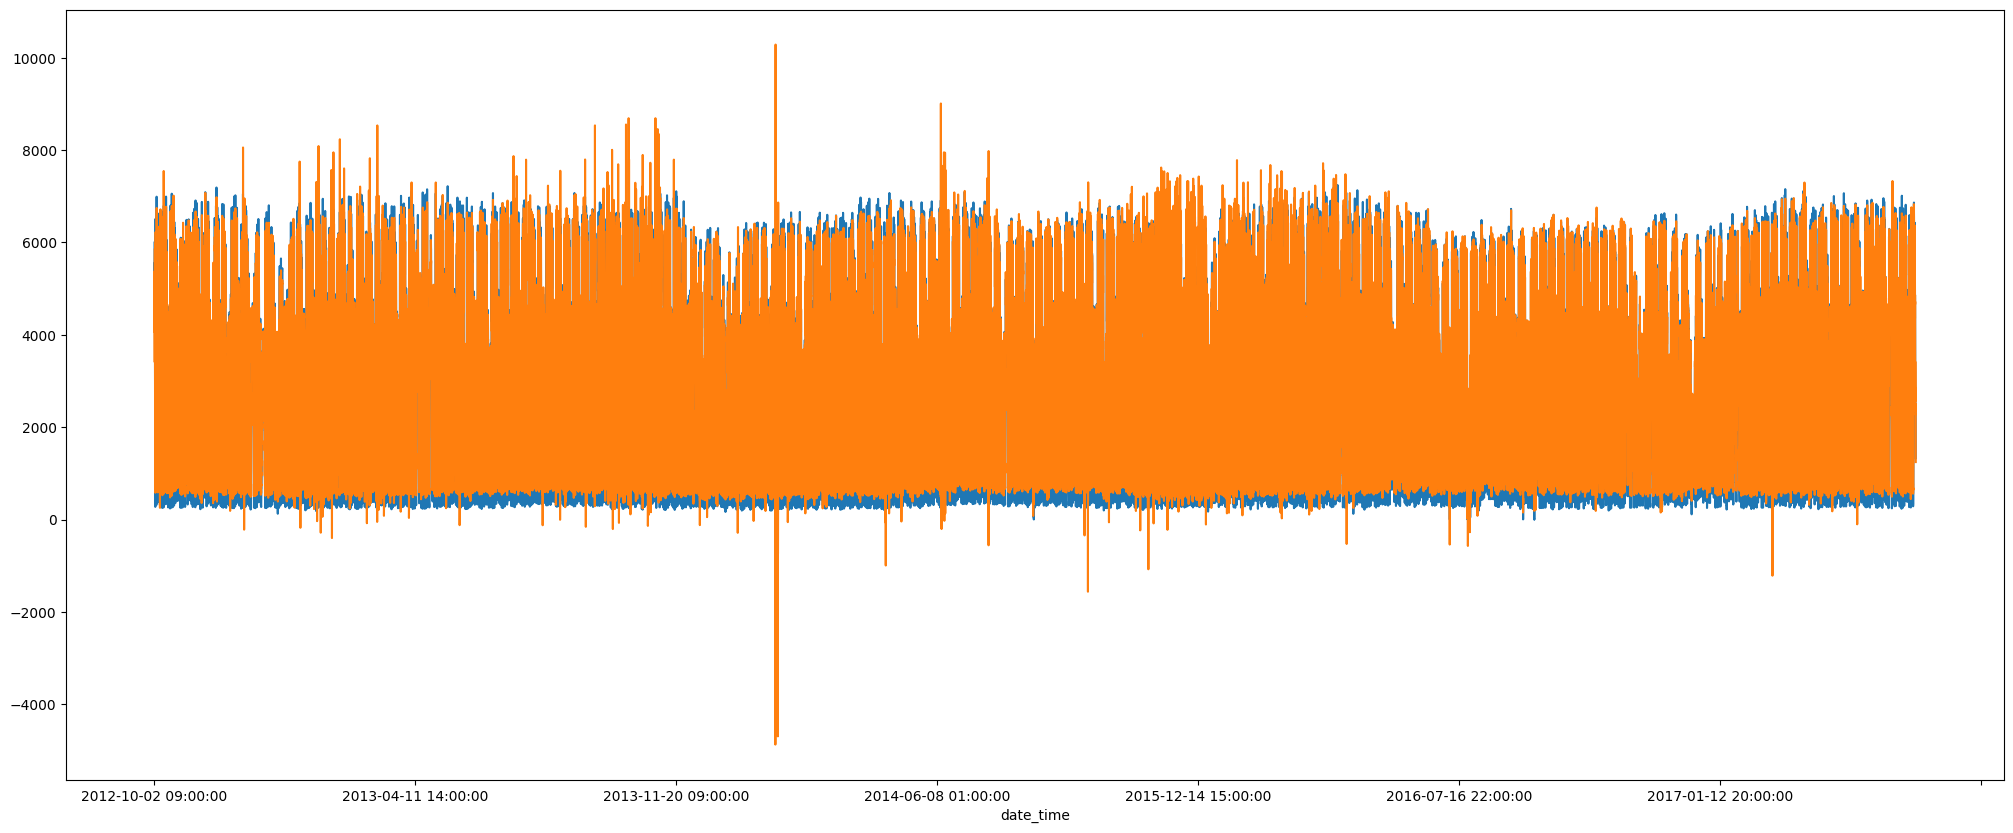

In [26]:
train['traffic_volume'].plot(figsize=(25,10))
model_fit.fittedvalues.plot()
plt.show()

With this piece of code, we shall perform model inference. 
We'll use our hold-out test set for this. Using the exogenous variables, we'll provide input into our fitted ARIMAX model, and obtain the predcitions for `traffic_volume`

In [27]:
predict = model_fit.predict(start = len(train),end = len(train)+len(test)-1,exog = sm.add_constant(test[[
    'air_pollution_index',
    'humidity',
    'wind_speed',
    'wind_direction',
    'visibility_in_miles',
    'dew_point',
    'temperature',
    'rain_p_h',
    'snow_p_h',
    'clouds_all'
]]))
test['predicted'] = predict.values
test.tail(5)

,date_time,is_holiday,air_pollution_index,humidity,wind_speed,wind_direction,visibility_in_miles,dew_point,temperature,rain_p_h,snow_p_h,clouds_all,weather_type,weather_description,predicted
14449,2018-09-30 19:00:00,NaN,176,21,4,345,4,4,283.45,0.0,0,75,Clouds,broken clouds,3276.751473
14450,2018-09-30 20:00:00,NaN,214,95,8,280,6,6,282.76,0.0,0,90,Clouds,overcast clouds,3424.671194
14451,2018-09-30 21:00:00,NaN,173,63,4,238,1,1,282.73,0.0,0,90,Thunderstorm,proximity thunderstorm,3326.540922
14452,2018-09-30 22:00:00,NaN,21,57,8,268,7,7,282.09,0.0,0,90,Clouds,overcast clouds,3369.134823
14453,2018-09-30 23:00:00,NaN,116,70,8,328,6,6,282.12,0.0,0,90,Clouds,overcast clouds,3379.852160


We've defined 2 metrics here - MAE and MAPE, to quantify our loss here. Can't calculate because the test data doesnt contain `traffic_volume` column

This how we will calculate it: 
* 
MAE = mean_absolute_error(test["traffic_volume"], test["predicted"]) \
RMSE = math.sqrt(mean_squared_error(test["traffic_volume"], test["predicted"])) \
print("MAE:", MAE) \
print("RMSE:", RMSE) 

 Question 2: Your task is to use the above learnings, and apply a SARIMAX model. Do reuse the code, identify a suitable seasonal order, and experiment to find the best performing model! Also, provide your reasoning for choosing your seasonal order!

> Hint: In your model definition step, you'll have to provide a `seasonal_order` parameter along with `order`. 

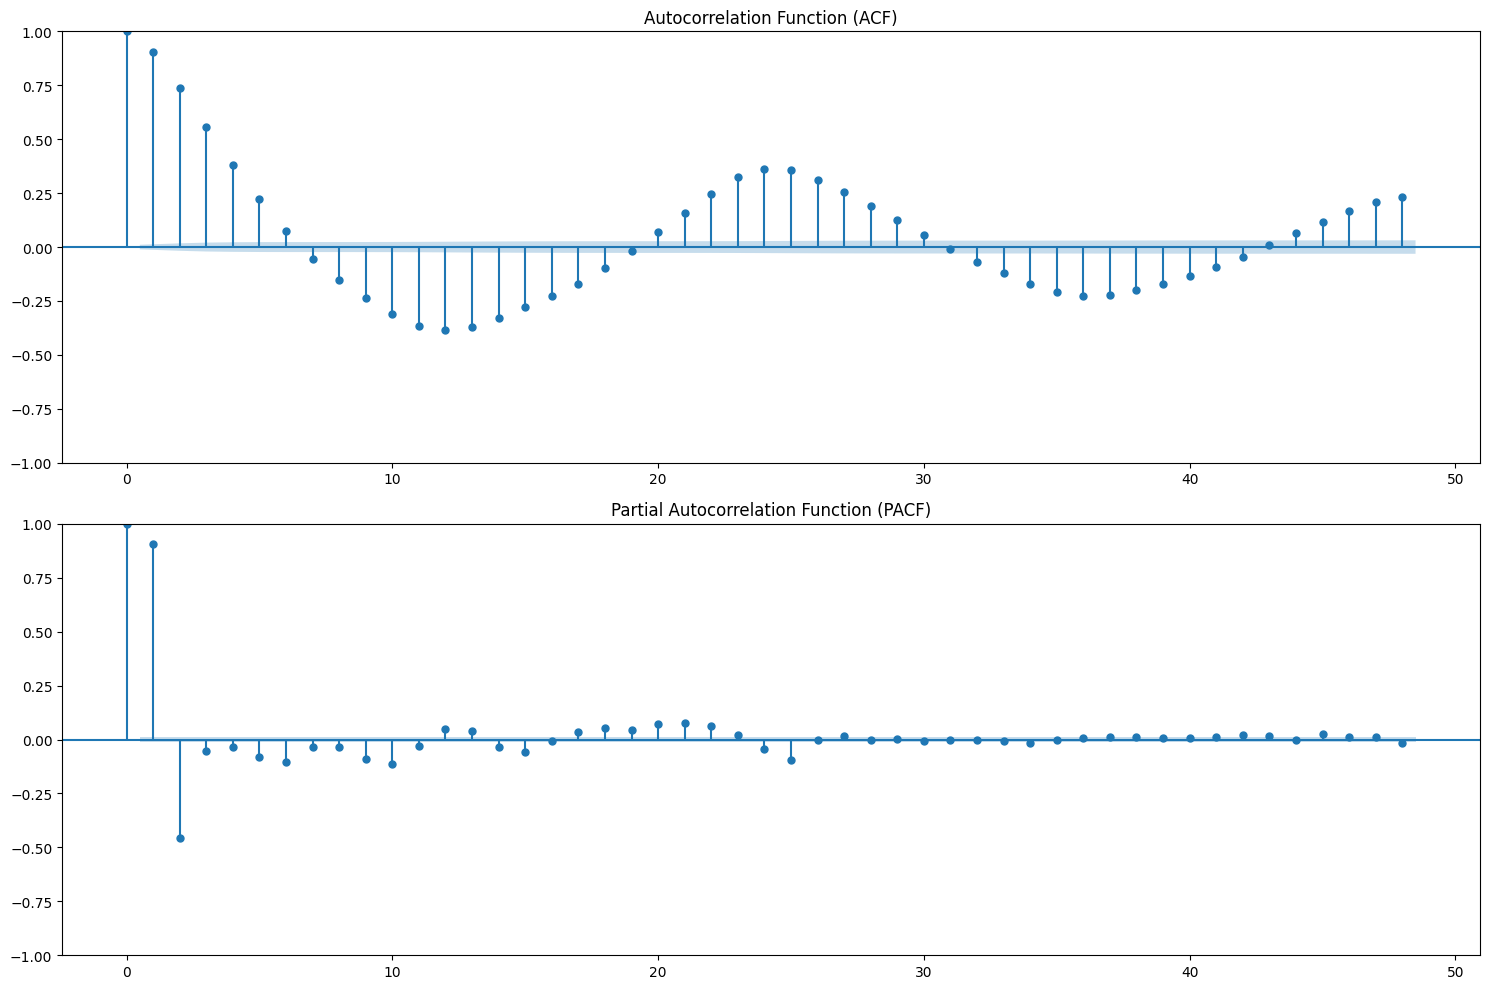

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           16     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.05428D+00    |proj g|=  8.68418D-02

At iterate    5    f=  8.04905D+00    |proj g|=  1.63553D-02

At iterate   10    f=  8.04636D+00    |proj g|=  3.88077D-03

At iterate   15    f=  8.04564D+00    |proj g|=  6.80845D-03

At iterate   20    f=  8.04444D+00    |proj g|=  1.45341D-03

At iterate   25    f=  8.04412D+00    |proj g|=  3.44580D-04

At iterate   30    f=  8.04410D+00    |proj g|=  2.40698D-04

At iterate   35    f=  8.04403D+00    |proj g|=  5.58243D-04

At iterate   40    f=  8.04401D+00    |proj g|=  3.98665D-04

At iterate   45    f=  8.04398D+00    |proj g|=  2.43739D-03

At iterate   50    f=  8.04381D+00    |proj g|=  3.20556D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

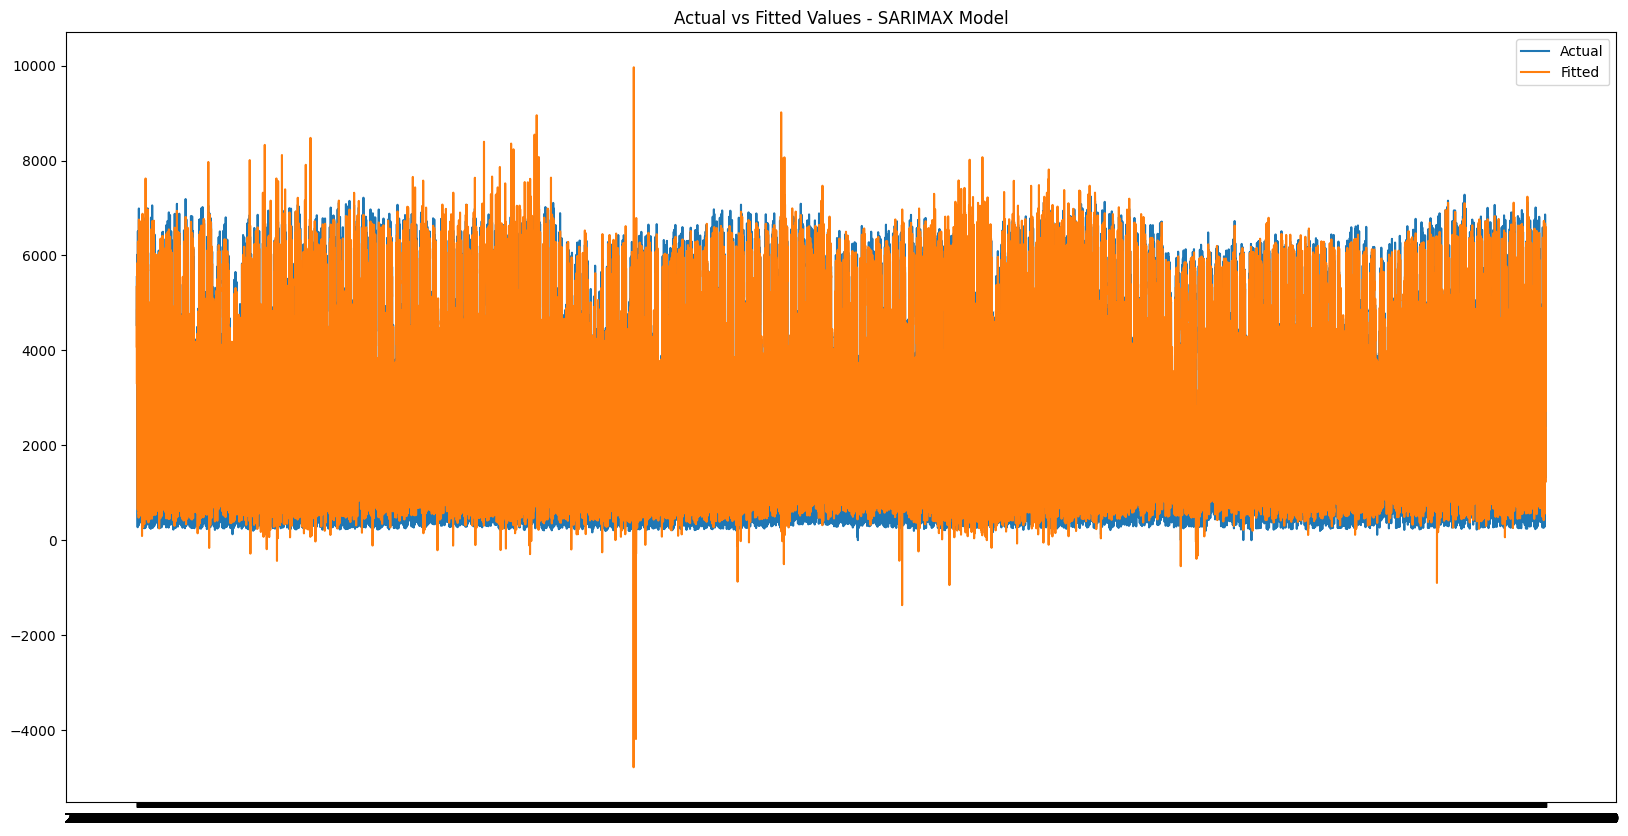

In [28]:
# Your answer here
plt.figure(figsize=(15, 10))

# Plot ACF (Autocorrelation Function)
plt.subplot(211)
plot_acf(train['traffic_volume'], lags=48, ax=plt.gca())
plt.title('Autocorrelation Function (ACF)')

# Plot PACF (Partial Autocorrelation Function)
plt.subplot(212)
plot_pacf(train['traffic_volume'], lags=48, ax=plt.gca())
plt.title('Partial Autocorrelation Function (PACF)')

plt.tight_layout()
plt.show()

# Explanation:
# The ACF and PACF plots are generated with 48 lags to identify any repeating patterns in traffic volume.
# Given that traffic volume typically exhibits daily cycles—such as peak volumes during rush hours—it's likely that
# the data will show significant autocorrelation at lags that correspond to a 24-hour cycle.
# Observing these correlations will help in determining appropriate model parameters for seasonality.

# Define exogenous variables that may influence traffic volume (e.g., weather conditions)
exog_columns = [
    'air_pollution_index', 'humidity', 'wind_speed', 'wind_direction',
    'visibility_in_miles', 'dew_point', 'temperature', 'rain_p_h',
    'snow_p_h', 'clouds_all'
]
exog = sm.add_constant(train[exog_columns])  # Add a constant term to the exogenous variables
endog = train['traffic_volume']  # Target variable: traffic volume

# Fit the SARIMAX model including seasonal components
# The order=(1,0,1) is selected based on previous analyses of the data's characteristics.
# For seasonal_order=(1,0,1,24):
# P=1 indicates that traffic volume at the same hour on different days may be related,
# D=0 suggests that no differencing is needed to address seasonal trends in the data,
# Q=1 allows for accounting seasonal shocks or fluctuations that recur every 24 hours,
# and s=24 is appropriate due to the hourly frequency of the traffic volume data, reflecting a daily seasonal pattern.
model = sm.tsa.statespace.SARIMAX(
    endog=endog,           # Endogenous variable (traffic volume)
    exog=exog,             # Exogenous variables (weather, air quality, etc.)
    order=(1,0,1),         # ARIMA order for capturing short-term dependencies
    seasonal_order=(1,0,1,24)  # SARIMA seasonal order for daily seasonality (24-hour cycle)
)

# Fit the model with a maximum of 50 iterations to ensure convergence
model_fit = model.fit(maxiter=50)
print(model_fit.summary())

# Plot actual vs. fitted values to assess the model's fit
plt.figure(figsize=(20,10))
plt.plot(train.index, train['traffic_volume'], label='Actual')
plt.plot(train.index, model_fit.fittedvalues, label='Fitted')
plt.legend()
plt.title('Actual vs Fitted Values - SARIMAX Model')
plt.show()

# Explanation of seasonal_order=(1,0,1,24):
# The parameter s=24 is selected as the data is recorded hourly, indicating that traffic volume patterns tend to repeat daily.
# P=1 signifies that traffic volumes at the same hour across different days show dependency,
# D=0 indicates that the data does not require seasonal differencing to stabilize the seasonal component,
# and Q=1 addresses seasonal noise or shocks that can occur at the same time daily.


The seasonal order is specified as (1, 0, 1, 24), with the parameter s=24 selected because the traffic volume data is collected hourly, and traffic patterns typically follow a daily cycle. Therefore, a 24-hour seasonal cycle is utilized to effectively capture these recurring trends.

Model Complexity and Performance:
This model includes all variables, leading to a notable increase in execution time compared to the previous SARIMAX model. This heightened complexity not only impacts computational efficiency but may also compromise the model’s accuracy.

Key performance metrics, such as tint, tnf, F-statistic, and progj score, illustrate these trade-offs, emphasizing the challenges associated with the increased complexity of this approach.

As before, a plot ACF and PACF of differenced time series can be used to find non-seasonal orders p and q. However, to find seasonal orders P and Q we need to plot ACF and PACF of the differenced time series at multiple seasonal steps.

From the graph, P and Q can be found

Reference :\
https://www.jadsmkbdatalab.nl/forecasting-with-sarimax-models/#:~:text=However%2C%20to%20find%20seasonal%20orders,series%20at%20multiple%20seasonal%20steps.&text=From%20left%20to%20right%3A,S%3D7

## LSTMs

Long Short-Term Memory (LSTM) is a type of recurrent neural network (RNN) architecture in deep learning. LSTMs are designed to address the vanishing gradient problem in traditional RNNs, allowing them to effectively capture and model long-range dependencies in sequential data. They have become a crucial tool for tasks like natural language processing, time series forecasting, and sequential pattern recognition.

LSTMs are often used to effectively model complicated time-series problems, so we'll explore this further.

For the scope of this worksheet, we'll only use the target variable and it's lags as input to the LSTM. However, you're encouraged to explore how the entire input dataset can be modeled as input to the model.

Our first task would be to convert our time-series forecasting problem, into a supervised learning problem. Any ideas on how we can achieve this?

Let's first learn the distinction between a time series, and a supervised learning problem.

A time series is a sequence of numbers that are ordered by a time index. This can be thought of as a list or column of ordered values.

A supervised learning problem comprises input patterns (X) and output patterns (y), such that an algorithm can learn how to predict the output patterns from the input patterns.

Pandas has a `shift()` function, that we can use to extract **lags** from the target variable. In essence, we want to somehow bring a X->y relation with respect to the target variable, while retaining the time component.

So, what are *lags*?

Lags refer to the practice of shifting a time series data point or variable backward in time by a certain number of time units.

If you're able to understand where this is going now....

We're essentially going to create a mapping such that : 

`var(t - 1) -> var(t)`; which resembles `X -> y` !

We can go further here, and take more lags, such as `var(t - 2), var(t - 3)`, etc.!

Incase you found this prelude a little difficult to follow, consider going through a more detailed write-up here: 

[Machine Learning Mastery's Blog on converting time series to supervised learning](https://machinelearningmastery.com/convert-time-series-supervised-learning-problem-python/)

## Applying LSTM to our dataset

In [29]:
df = pd.read_csv("/kaggle/input/ist-traffic-and-weather-time-series-dataset/Train.csv", encoding = "unicode_escape")

In [30]:
np.random.seed(11)
dataframe = df.loc[:,'traffic_volume']
dataset = dataframe.values
dataset = dataset.astype('float32')

For this demonstration purpose, we'll use lags of 7 days, and convert it into a supervised learning problem. 

Here's a function that's borrowed from the aforementioned blog, that helps us in converting the time series to a supervised problem - 

In [31]:
# convert series to supervised learning
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1
    df = pd.DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

In [32]:
new_dataset = series_to_supervised(dataset, 7,1)
new_dataset.head(3)

,var1(t-7),var1(t-6),var1(t-5),var1(t-4),var1(t-3),var1(t-2),var1(t-1),var1(t)
7,5545.0,4516.0,4767.0,5026.0,4918.0,5181.0,5584.0,6015.0
8,4516.0,4767.0,5026.0,4918.0,5181.0,5584.0,6015.0,5791.0
9,4767.0,5026.0,4918.0,5181.0,5584.0,6015.0,5791.0,4770.0


Just to give a taste of multivariate time-series forecasting using LSTMs - we'll use `temperature` and `wind_speed` in our input to the model as well:

In [33]:
new_dataset['temperature'] = df.temperature.values[7:]
new_dataset['wind_speed']= df.wind_speed.values[7:]

In [34]:
new_dataset = new_dataset.reindex(['temperature', 'wind_speed','var1(t-7)', 'var1(t-6)', 'var1(t-5)', 'var1(t-4)', 'var1(t-3)','var1(t-2)', 'var1(t-1)', 'var1(t)'], axis=1)
new_dataset = new_dataset.values

**Remember - we cannot use DataFrames, as LSTMs (and most other deep learning models) only accept tensors as input!**

In [35]:
type(new_dataset)

numpy.ndarray

We'll scale our features between 0 and 1 - this would be to help the process of gradient descent.

In [36]:
scaler = MinMaxScaler(feature_range=(0, 1))
new_dataset = scaler.fit_transform(new_dataset)

We'll split our dataset into train and test, as done for ARIMAX. Remember, it is still inherently a time series problem, so we will not use a random split.

In [37]:
train_lstm = new_dataset[:(len(new_dataset)-30), :]
test_lstm = new_dataset[(len(new_dataset)-30):len(new_dataset), :]

We adjust the labels, such that `train_X` and `test_X` contain the features, and `train_Y`, `test_Y` contain the target

In [38]:
train_X, train_y = train_lstm[:, :-1], train_lstm[:, -1]
test_X, test_y = test_lstm[:, :-1], test_lstm[:, -1]

The input to a LSTM is 3D - in this format: (samples, timesteps, features). We'll go ahead and reshape our train and tests sets as such

In [39]:
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(33713, 1, 9) (33713,) (30, 1, 9) (30,)


## LSTM Modeling!

Epoch 1/50
469/469 - 3s - 6ms/step - loss: 0.1260
Epoch 2/50
469/469 - 1s - 2ms/step - loss: 0.0691
Epoch 3/50
469/469 - 1s - 2ms/step - loss: 0.0648
Epoch 4/50
469/469 - 1s - 2ms/step - loss: 0.0635
Epoch 5/50
469/469 - 1s - 3ms/step - loss: 0.0627
Epoch 6/50
469/469 - 1s - 2ms/step - loss: 0.0622
Epoch 7/50
469/469 - 1s - 2ms/step - loss: 0.0620
Epoch 8/50
469/469 - 1s - 2ms/step - loss: 0.0617
Epoch 9/50
469/469 - 1s - 2ms/step - loss: 0.0615
Epoch 10/50
469/469 - 1s - 2ms/step - loss: 0.0614
Epoch 11/50
469/469 - 1s - 2ms/step - loss: 0.0613
Epoch 12/50
469/469 - 1s - 2ms/step - loss: 0.0612
Epoch 13/50
469/469 - 1s - 2ms/step - loss: 0.0610
Epoch 14/50
469/469 - 1s - 2ms/step - loss: 0.0608
Epoch 15/50
469/469 - 1s - 2ms/step - loss: 0.0606
Epoch 16/50
469/469 - 1s - 2ms/step - loss: 0.0603
Epoch 17/50
469/469 - 1s - 2ms/step - loss: 0.0600
Epoch 18/50
469/469 - 1s - 2ms/step - loss: 0.0596
Epoch 19/50
469/469 - 1s - 2ms/step - loss: 0.0592
Epoch 20/50
469/469 - 1s - 2ms/step - lo

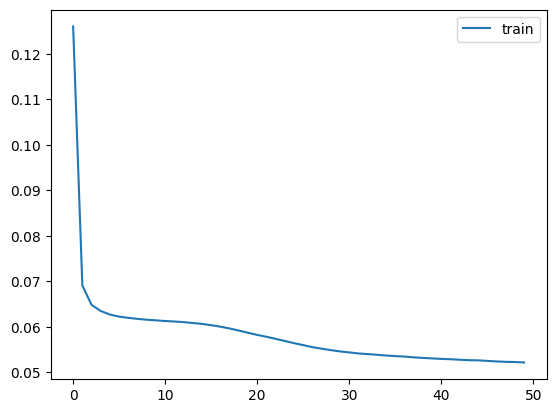

In [40]:
model = Sequential()
model.add(LSTM(32, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dense(1))
model.compile(loss='mae', optimizer='adam')
# fit network
history = model.fit(train_X, train_y, epochs=50, batch_size=72, verbose=2, shuffle=False)
# plot history
plt.plot(history.history['loss'], label='train')
plt.legend()
plt.show()

## LSTM Inferencing (Model Prediction)

Since we went through the whole charade of Scaling our values - making a prediction isn't completely straightforward.
We need to invert the scaling, in order to obtain the correct forecast value.

In [41]:
# make a prediction
yhat = model.predict(test_X)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step


In [42]:
test_X = test_X.reshape(test_X.shape[0], test_X.shape[2])

In [43]:
inv_yhat = np.concatenate((yhat, test_X), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)

In [44]:
# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y = np.concatenate((test_y, test_X), axis=1)
inv_y = scaler.inverse_transform(inv_y)

### Checking the performance of the model

In [45]:
act = [i[0] for i in inv_y] # last element is the predicted power consumption
pred = [i[0] for i in inv_yhat] # last element is the actual power consumption

In [46]:
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error

mae = mean_absolute_error(act, pred)
rmse = math.sqrt(mean_squared_error(act, pred))
print("MAE:", mae)
print("RMSE:", rmse)

MAE: 14.255611010587785
RMSE: 20.61537742094709


Question 3: Can we use accuracy as a metric for this particular problem? Why or why not?

In [47]:
# Your answer here

Using accuracy as a metric for evaluating this problem is inappropriate. Accuracy measures the proportion of correct predictions and is mainly applicable to classification tasks where outcomes are categorical. In contrast, this problem focuses on forecasting continuous values, making accuracy less relevant for assessing model performance.

For a forecasting model like SARIMAX, it is more appropriate to employ quantitative error metrics that gauge the differences between actual and predicted values. Metrics such as Mean Absolute Error (MAE), Mean Absolute Percentage Error (MAPE), and Root Mean Squared Error (RMSE) offer a more accurate evaluation of the model's performance in this context.

In summary, accuracy is not suitable for assessing continuous predictions. Instead, using error metrics like MSE and MAE, which we have applied in this worksheet and previous exercises, provides a more reliable approach to evaluating the model's effectiveness.








Question 4: When can LSTMs outperform ARIMA, ARIMAX or SARIMAX models? Is it worth the computational expense to fit an LSTM over a traditional time series model?

In [48]:
# Your answer here

LSTMs (Long Short-Term Memory networks) often outperform ARIMA-based models in situations involving long-term dependencies, non-linear relationships, or non-stationary data that does not require transformations. LSTMs are particularly effective at retaining information across multiple time lags, allowing them to handle complex time series with intricate patterns or significant noise.

Although LSTMs require substantial computational resources, their application is warranted when dealing with complex, non-linear time series or when multivariate inputs are involved. In contrast, for simpler or linear time series problems, traditional models like ARIMA, ARIMAX, or SARIMAX are usually sufficient, providing greater interpretability and computational efficiency.








Question 5: What can you elucidate about the interpretability of ARIMA/ARIMAX vs LSTMs?

Hint: Think black-box models

In [49]:
# Your answer here

ARIMA and ARIMAX models are highly interpretable because they rely on clear mathematical principles. This allows for straightforward understanding of how lagged terms and other variables influence predictions. For instance, if you modify a variable, it’s easy to see its impact on the outcome. This transparency is particularly valuable in contexts where explaining the model's decisions is crucial, such as in finance or healthcare.

In contrast, LSTMs (Long Short-Term Memory networks) operate more like black boxes. They are part of deep learning and feature complex architectures that obscure their internal processes. Although LSTMs typically achieve superior accuracy, this comes at the cost of clarity; it’s challenging to discern how predictions are made, as the mechanisms behind weight adjustments are not easily understood.

Therefore, the choice between ARIMA/ARIMAX and LST

### Congratulations on making it to the end of the worksheet! I hope you have a much better understanding of modeling the time-series workflow, and applications of Deep Learning methods too!

### Incase you want to explore further, Facebook Prophet is a great time series model as well to have in your toolbox!
### Read more [here!](https://www.kaggle.com/code/prashant111/tutorial-time-series-forecasting-with-prophet)